# 전이 학습 프로그래밍 : 벌/개미 분류

In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OyUrQ5FZHl4VT1pe0nvY1ARQZxsclUYF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1OyUrQ5FZHl4VT1pe0nvY1ARQZxsclUYF" -O hymenoptera_data.zip && rm -rf /tmp/cookies.txt
!unzip /content/hymenoptera_data.zip


--2021-05-08 16:21:41--  https://docs.google.com/uc?export=download&confirm=srA_&id=1OyUrQ5FZHl4VT1pe0nvY1ARQZxsclUYF
Resolving docs.google.com (docs.google.com)... 64.233.189.102, 64.233.189.138, 64.233.189.113, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-9k-docs.googleusercontent.com/docs/securesc/ha3jd8j7bbnq4cd5m9d5f4iv47rr5jfb/7d90a0nlbi9tqtlha42agd773l0rbbq9/1620490875000/09229857921079060417/04301984599912028296Z/1OyUrQ5FZHl4VT1pe0nvY1ARQZxsclUYF?e=download [following]
--2021-05-08 16:21:42--  https://doc-00-9k-docs.googleusercontent.com/docs/securesc/ha3jd8j7bbnq4cd5m9d5f4iv47rr5jfb/7d90a0nlbi9tqtlha42agd773l0rbbq9/1620490875000/09229857921079060417/04301984599912028296Z/1OyUrQ5FZHl4VT1pe0nvY1ARQZxsclUYF?e=download
Resolving doc-00-9k-docs.googleusercontent.com (doc-00-9k-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting

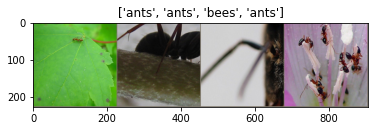

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import time
import os
import copy


#학습을 위해 데이터 증가 및 일반화
data_transforms = {
    'train' : transforms.Compose([
                                  transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                
    ])
}

batch_size = 4

data_dir = '/content/hymenoptera_data'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
trainloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, pin_memory=True)
testloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, pin_memory=True)

dataset_sizes = {len(train_dataset), len(test_dataset)}
class_names = train_dataset.classes

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #갱신될때까지 잠시 기다림

#학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(trainloader))

#배치로부터 격자 형태의 이미지를 만듬
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

# Resnet VS VGG VS GoogleNet

## 1. Resnet18

==>Epoch[1/20]
loss: 1.0622695840773035, accuracy: 0.4549180269241333, val_loss:0.9788898924986521, val_accuracy:0.4423076808452606
==>Epoch[2/20]
loss: 0.7905627586802498, accuracy: 0.5122950673103333, val_loss:0.8922450951276681, val_accuracy:0.5320512652397156
==>Epoch[3/20]
loss: 0.7506884175245879, accuracy: 0.5450819730758667, val_loss:0.9980900205480747, val_accuracy:0.5128205418586731
==>Epoch[4/20]
loss: 0.7076448964290931, accuracy: 0.5655737519264221, val_loss:2.9723306879019127, val_accuracy:0.48076921701431274
==>Epoch[5/20]
loss: 0.7526747628313596, accuracy: 0.5532786846160889, val_loss:0.7070173468345251, val_accuracy:0.5256410241127014
==>Epoch[6/20]
loss: 0.7490456133592324, accuracy: 0.5778688788414001, val_loss:1.08026352381477, val_accuracy:0.5128205418586731
==>Epoch[7/20]
loss: 0.706040347697305, accuracy: 0.5655737519264221, val_loss:1.1288023231885371, val_accuracy:0.5512820482254028
==>Epoch[8/20]
loss: 0.6996355809149195, accuracy: 0.5819672346115112, val_los

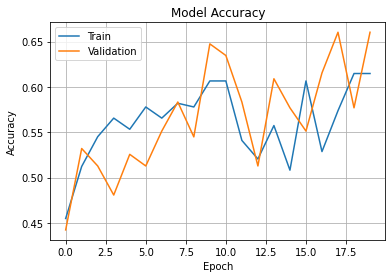

In [49]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)
'''
# 부분 빼면 미세조정 방식 : 컨볼루션층과 완전연결층의 가중치를 동시에 수정
# 부분 포함 동결 방식 : 컨볼루션의 가중치를 동결하여 완전연결층의 가중치만 수정되도록
'''
model = model.cuda()

criterion = CrossEntropyLoss()
optimizer_conv = optim.Adam(model.parameters(), lr = 0.002)
epochs = 20

#train code
t_accs, v_accs, t_loss, v_loss = [], [], [], []
for epoch in range(epochs):
    train_loss=0
    train_accuracy=0
    model.train()

    for images, labels in trainloader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer_conv.zero_grad()

        output = model(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))

        loss = criterion(output, labels)
        loss.backward()
        optimizer_conv.step()
        train_loss += loss.item()

    t_accs.append(train_accuracy/len(trainloader))
    t_loss.append(train_loss/len(trainloader))

    ## validation
    test_loss =0
    test_accuracy = 0
    model.eval()
    for images, labels in testloader:
        images = images.cuda()
        labels = labels.cuda()
        log_ps = model(images)
        test_loss += criterion(log_ps, labels).item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class ==labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    v_accs.append(test_accuracy/len(testloader))
    v_loss.append(test_loss/len(testloader))

    print("==>Epoch[{}/{}]".format(epoch+1, epochs))
    print("loss: {}, accuracy: {}, val_loss:{}, val_accuracy:{}".format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))


plt.title("Model Accuracy")
plt.plot(t_accs, label='Training Accuracy')
plt.plot(v_accs, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()

## 2. vgg19

==>Epoch[1/20]
loss: 1.3307991975643596, accuracy: 0.5204917788505554, val_loss:2.0669114757806826, val_accuracy:0.4743589758872986
==>Epoch[2/20]
loss: 0.8248738040689563, accuracy: 0.4713114798069, val_loss:1.4268582588634813, val_accuracy:0.48076921701431274
==>Epoch[3/20]
loss: 0.7736057267814386, accuracy: 0.4836065471172333, val_loss:0.8955483107994764, val_accuracy:0.48076921701431274
==>Epoch[4/20]
loss: 0.7638986486880506, accuracy: 0.5204917788505554, val_loss:0.6957037586432236, val_accuracy:0.4743589758872986
==>Epoch[5/20]
loss: 0.7695954002317835, accuracy: 0.48770493268966675, val_loss:1.5961365948120751, val_accuracy:0.45512819290161133
==>Epoch[6/20]
loss: 0.7027731977525304, accuracy: 0.5696721076965332, val_loss:0.7456500178728348, val_accuracy:0.4294871687889099
==>Epoch[7/20]
loss: 0.6967658009685453, accuracy: 0.5450819730758667, val_loss:0.728430430094401, val_accuracy:0.46794870495796204
==>Epoch[8/20]
loss: 0.6906702733430706, accuracy: 0.5573770403862, val_los

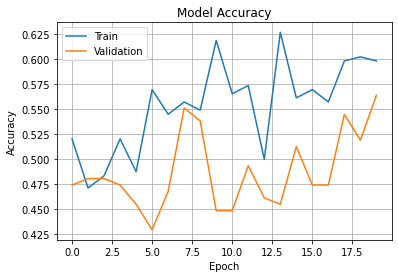

In [44]:
model = models.vgg19_bn(pretrained=True)
model.classifier = nn.Linear(25088, 2)
'''
# 부분 빼면 미세조정 방식 : 컨볼루션층과 완전연결층의 가중치를 동시에 수정
# 부분 포함 동결 방식 : 컨볼루션의 가중치를 동결하여 완전연결층의 가중치만 수정되도록
'''
model = model.cuda()

criterion = CrossEntropyLoss()
optimizer_conv = optim.Adam(model.parameters(), lr = 0.002)
epochs = 20

#train code
t_accs, v_accs, t_loss, v_loss = [], [], [], []
for epoch in range(epochs):
    train_loss=0
    train_accuracy=0
    model.train()

    for images, labels in trainloader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer_conv.zero_grad()

        output = model(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))

        loss = criterion(output, labels)
        loss.backward()
        optimizer_conv.step()
        train_loss += loss.item()

    t_accs.append(train_accuracy/len(trainloader))
    t_loss.append(train_loss/len(trainloader))

    ## validation
    test_loss =0
    test_accuracy = 0
    model.eval()
    for images, labels in testloader:
        images = images.cuda()
        labels = labels.cuda()
        log_ps = model(images)
        test_loss += criterion(log_ps, labels).item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class ==labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    v_accs.append(test_accuracy/len(testloader))
    v_loss.append(test_loss/len(testloader))

    print("==>Epoch[{}/{}]".format(epoch+1, epochs))
    print("loss: {}, accuracy: {}, val_loss:{}, val_accuracy:{}".format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))


plt.title("Model Accuracy")
plt.plot(t_accs, label='Training Accuracy')
plt.plot(v_accs, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()

## 3. googlenet

==>Epoch[1/20]
loss: 0.8037540446356183, accuracy: 0.5901639461517334, val_loss:0.9364108072629674, val_accuracy:0.5833333134651184
==>Epoch[2/20]
loss: 0.7119178063556796, accuracy: 0.5573770403862, val_loss:1.0823647104776823, val_accuracy:0.44871795177459717
==>Epoch[3/20]
loss: 0.7213370653449512, accuracy: 0.5040983557701111, val_loss:1.6545436833149347, val_accuracy:0.45512819290161133
==>Epoch[4/20]
loss: 0.7065812691313321, accuracy: 0.5901639461517334, val_loss:0.8667794095400052, val_accuracy:0.5512820482254028
==>Epoch[5/20]
loss: 0.8010619429291271, accuracy: 0.4590163826942444, val_loss:1.45575693440743, val_accuracy:0.49358972907066345
==>Epoch[6/20]
loss: 0.7642244955555337, accuracy: 0.5122950673103333, val_loss:1.0969643871752652, val_accuracy:0.5384615659713745
==>Epoch[7/20]
loss: 0.719110307634854, accuracy: 0.5368852615356445, val_loss:1.1140121267392085, val_accuracy:0.43589743971824646
==>Epoch[8/20]
loss: 0.7160681715754212, accuracy: 0.5532786846160889, val_los

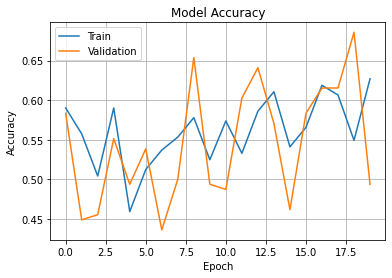

In [46]:
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(1024, 2)
'''
# 부분 빼면 미세조정 방식 : 컨볼루션층과 완전연결층의 가중치를 동시에 수정
# 부분 포함 동결 방식 : 컨볼루션의 가중치를 동결하여 완전연결층의 가중치만 수정되도록
'''
model = model.cuda()

criterion = CrossEntropyLoss()
optimizer_conv = optim.Adam(model.parameters(), lr = 0.002)
epochs = 20

#train code
t_accs, v_accs, t_loss, v_loss = [], [], [], []
for epoch in range(epochs):
    train_loss=0
    train_accuracy=0
    model.train()

    for images, labels in trainloader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer_conv.zero_grad()

        output = model(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))

        loss = criterion(output, labels)
        loss.backward()
        optimizer_conv.step()
        train_loss += loss.item()

    t_accs.append(train_accuracy/len(trainloader))
    t_loss.append(train_loss/len(trainloader))

    ## validation
    test_loss =0
    test_accuracy = 0
    model.eval()
    for images, labels in testloader:
        images = images.cuda()
        labels = labels.cuda()
        log_ps = model(images)
        test_loss += criterion(log_ps, labels).item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class ==labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    v_accs.append(test_accuracy/len(testloader))
    v_loss.append(test_loss/len(testloader))

    print("==>Epoch[{}/{}]".format(epoch+1, epochs))
    print("loss: {}, accuracy: {}, val_loss:{}, val_accuracy:{}".format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))


plt.title("Model Accuracy")
plt.plot(t_accs, label='Training Accuracy')
plt.plot(v_accs, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()

# 2. 데이터 증대 비교 

- RandomHorizontalFlip()



## 1. ToTensor() 만 적용


In [67]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor #읽어드린 값을 텐서로 바꾸기 위함

batch_size = 256
train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
trainloader = DataLoader(train_dataset, batch_size = batch_size)
testloader = DataLoader(test_dataset, batch_size = batch_size)


#모델 선언
model = LeNet5().cuda() #gpu 할당
optimizer = SGD(model.parameters(), lr=1e-1)
criterion = CrossEntropyLoss()
epochs = 10

#train code
t_accs, v_accs, t_loss, v_loss = [], [], [], []
for epoch in range(epochs):
    train_loss=0
    train_accuracy=0
    model.train()

    for images, labels in trainloader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        output = model(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    t_accs.append(train_accuracy/len(trainloader))
    t_loss.append(train_loss/len(trainloader))

    ## validation
    test_loss =0
    test_accuracy = 0
    model.eval()
    for images, labels in testloader:
        images = images.cuda()
        labels = labels.cuda()
        log_ps = model(images)
        test_loss += criterion(log_ps, labels).item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class ==labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    v_accs.append(test_accuracy/len(testloader))
    v_loss.append(test_loss/len(testloader))

    print("==>Epoch[{}/{}]".format(epoch+1, epochs))
    print("loss: {}, accuracy: {}. val_loss:{}, val_acc:{}".format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))

PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

==>Epoch[1/10]
loss: 1.878772675230148, accuracy: 0.3405695855617523. val_loss:1.470457747578621, val_acc:0.4471679627895355
==>Epoch[2/10]
loss: 0.9126953234063818, accuracy: 0.6642508506774902. val_loss:0.6720135778188705, val_acc:0.7593749761581421
==>Epoch[3/10]
loss: 0.6130401339936764, accuracy: 0.7638962864875793. val_loss:0.6140840634703636, val_acc:0.7710937261581421
==>Epoch[4/10]
loss: 0.5780852732506204, accuracy: 0.7708942890167236. val_loss:0.6028841599822045, val_acc:0.7748047113418579
==>Epoch[5/10]
loss: 0.558614756325458, accuracy: 0.775648295879364. val_loss:0.5807953327894211, val_acc:0.778124988079071
==>Epoch[6/10]
loss: 0.5443530498666966, accuracy: 0.7790060043334961. val_loss:0.5531540133059025, val_acc:0.7803710699081421
==>Epoch[7/10]
loss: 0.5348372070079154, accuracy: 0.7811669111251831. val_loss:0.5340461492538452, val_acc:0.783398449420929
==>Epoch[8/10]
loss: 0.5276346013901082, accuracy: 0.7823637127876282. val_loss:0.5260652489960194, val_acc:0.7839843

## ToTensor + **RandomHorizontalFlip()**

In [68]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor #읽어드린 값을 텐서로 바꾸기 위함

batch_size = 256

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                ])

train_dataset = mnist.MNIST(root='./train', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=transform, download=True)
trainloader = DataLoader(train_dataset, batch_size = batch_size)
testloader = DataLoader(test_dataset, batch_size = batch_size)


#모델 선언
model = LeNet5().cuda() #gpu 할당
optimizer = SGD(model.parameters(), lr=1e-1)
criterion = CrossEntropyLoss()
epochs = 10

#train code
t_accs, v_accs, t_loss, v_loss = [], [], [], []
for epoch in range(epochs):
    train_loss=0
    train_accuracy=0
    model.train()

    for images, labels in trainloader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        output = model(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    t_accs.append(train_accuracy/len(trainloader))
    t_loss.append(train_loss/len(trainloader))

    ## validation
    test_loss =0
    test_accuracy = 0
    model.eval()
    for images, labels in testloader:
        images = images.cuda()
        labels = labels.cuda()
        log_ps = model(images)
        test_loss += criterion(log_ps, labels).item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class ==labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    v_accs.append(test_accuracy/len(testloader))
    v_loss.append(test_loss/len(testloader))

    print("==>Epoch[{}/{}]".format(epoch+1, epochs))
    print("loss: {}, accuracy: {}. val_loss:{}, val_acc:{}".format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))

PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

==>Epoch[1/10]
loss: 2.0916256108182543, accuracy: 0.28832557797431946. val_loss:1.244644497334957, val_acc:0.5708984136581421
==>Epoch[2/10]
loss: 0.9401835066206912, accuracy: 0.673659086227417. val_loss:0.6775658696889877, val_acc:0.7533203363418579
==>Epoch[3/10]
loss: 0.501499388969325, accuracy: 0.8245068192481995. val_loss:0.28365818271413445, val_acc:0.9085937738418579
==>Epoch[4/10]
loss: 0.2201650987597222, accuracy: 0.9300587177276611. val_loss:0.18726937067694963, val_acc:0.9390624761581421
==>Epoch[5/10]
loss: 0.16818037525294943, accuracy: 0.9472295641899109. val_loss:0.14312401808565484, val_acc:0.9556640386581421
==>Epoch[6/10]
loss: 0.13887730935945156, accuracy: 0.955335795879364. val_loss:0.12322786950971931, val_acc:0.9598633050918579
==>Epoch[7/10]
loss: 0.11787353838853379, accuracy: 0.962267279624939. val_loss:0.10713180099846795, val_acc:0.9654296636581421
==>Epoch[8/10]
loss: 0.10341098545158797, accuracy: 0.9666168093681335. val_loss:0.09556437119026669, val_a

val_acc 가 데이터 증대 적용 전에는 0.78 부근에서 데이터 증대 적용 후, 0.96 부근까지 증가되는 것을 확인할 수 있다. (epoch 10만에 적용되는 큰 이점)